## Deep Learning from Ground Up

In this notebook, we are working our way up from Linear Regression, all the way to Deep Learning.

In [1]:
## first the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## some widgets to make the notebook more interactive
from ipywidgets import interact, FloatSlider

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

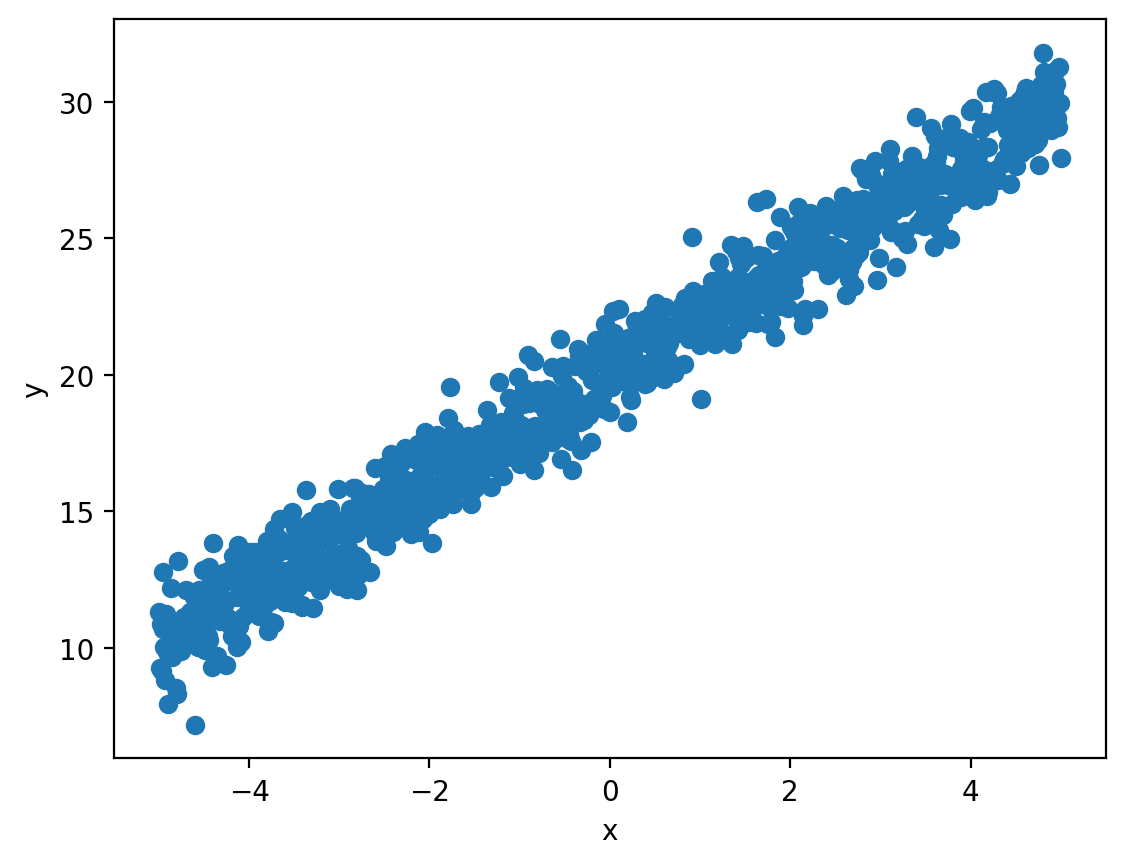

In [2]:
## creating some random data
n = 1000
w_true = 2
b_true = 20
x = np.linspace(-5, 5, n)
## creating a normally distributed noise
noise_fn = lambda x:np.random.normal(size = (x))

y = w_true * x + b_true + noise_fn(n)

## plotting our random data
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y');

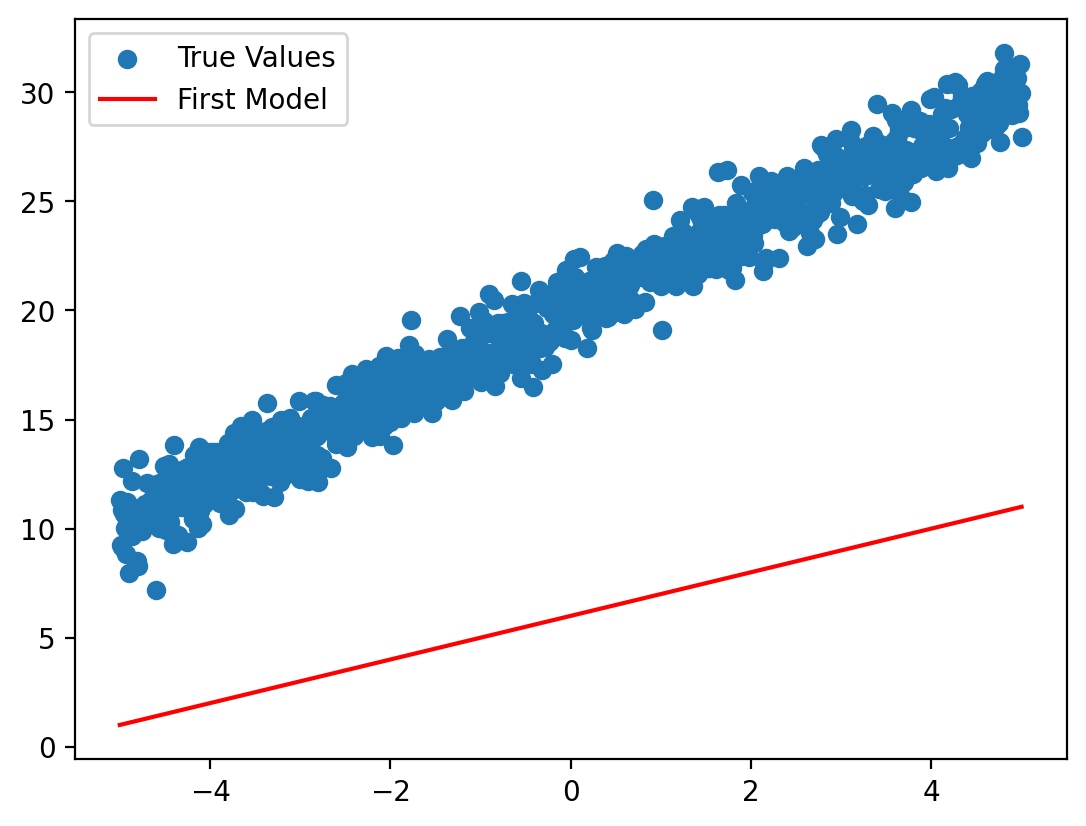

In [3]:
## starting with some bad first guesses
w = np.random.randint(0, 10)
b = np.random.randint(0, 10)
yhat = w * x + b
plt.scatter(x, y, label='True Values')
plt.plot(x, yhat, label='First Model', color='r')
plt.legend();

### Loss Function

In [4]:
## we will be using MSE as our loss function
def mse(y_pred, y_true):
    return np.mean((y_true - y_pred)**2)
## and now we can calculate the current model's loss
mse(yhat, y)

206.28273668748255

interactive(children=(FloatSlider(value=0.0, description='w', max=10.0, min=-10.0), FloatSlider(value=0.0, des…

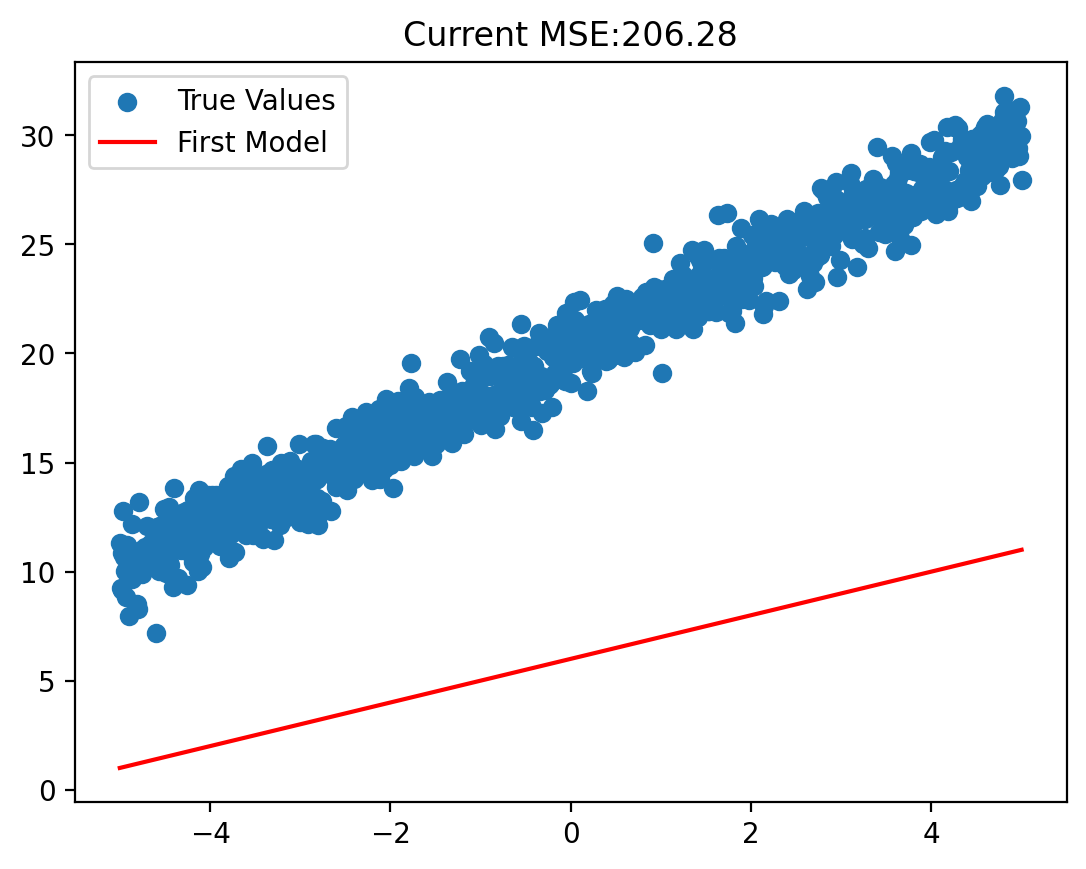

In [7]:
## manually changing the weight and bias
@interact(
    w = FloatSlider(min = -10, max = 10, step = .1),
    b = FloatSlider(min = -10, max = 10, step = .1)
)
def optimize_plot(w, b):
    yhat = w * x + b
    plt.scatter(x, y, label='True Values')
    plt.plot(x, yhat, label='First Model', color='r')
    plt.legend()
    plt.title(f'Current MSE:{mse(yhat, y):.2f}')
optimize_plot(w, b)

### Optimization

In order to optimize our loss, we have to get the derivatives of the function with respect to each of its variables.

In [28]:
## toy optimization problem
## that we can simply calculate the min by hand
def f(w):
    return w ** 2 + 3 * w - 5 
def df(w):
    return 2 * w + 3
## random start 
w = 10.5
## loop through to calculate the new value
for _ in range(1000):
    w = w - df(w) * 0.01
## the calculated min 
print(f'{w:.3}')

-1.5


In [89]:
## we will be using this library called jax
## which will enable us to automatically defferentiate 
## any arbitrary function in numpy
from jax import grad
from jax import numpy as jnp

## and now all we have to do is to re-write all of our functions
## in a way that jax can process
n = 1000
w_true = np.pi
b_true = np.pi * 2
x = np.linspace(-5, 5, n)
## when we're defining a model for jax
## the parameters should come first
def model(param, x):
    """
    :param param: parameters, a dictionary. Should have the 
        keys 'w' and 'b', which map to floating point numbers.
    :param x: input values for function
    """
    return param['w'] * x + param['b']
param_dict = {'w':np.random.normal(),
              'b':np.random.normal()}
true_param_dict = {'w':w_true,
              'b':b_true}
y_true = model(true_param_dict, x)
def mse(param, model, x, y):
    """
    :param param: parameters to optimize, a dictionary.
    :param x: input values for function
    :param y: true outputs
    """
    return np.mean((y - model(param, x))**2)
dmse = grad(mse)
lr = 0.01
loss_dict = {}
## and then the training loop
for e in range(200):
    grad_p = dmse(param_dict, model, x, y_true)
    ## calculating the loss
    loss_dict[e] = mse(param_dict, model, x, y_true)
    ## and then update the our keys
    ## and optimize our parameters
    for k in param_dict:
        param_dict[k] = ((param_dict[k] - grad_p[k]*lr))

print(f"True w: {true_param_dict['w']:.3f} calculated {param_dict['w']:.3f}")
print(f"True b: {true_param_dict['b']:.3f} calculated {param_dict['b']:.3f}")

True w: 3.142 calculated 3.142
True b: 6.283 calculated 6.164


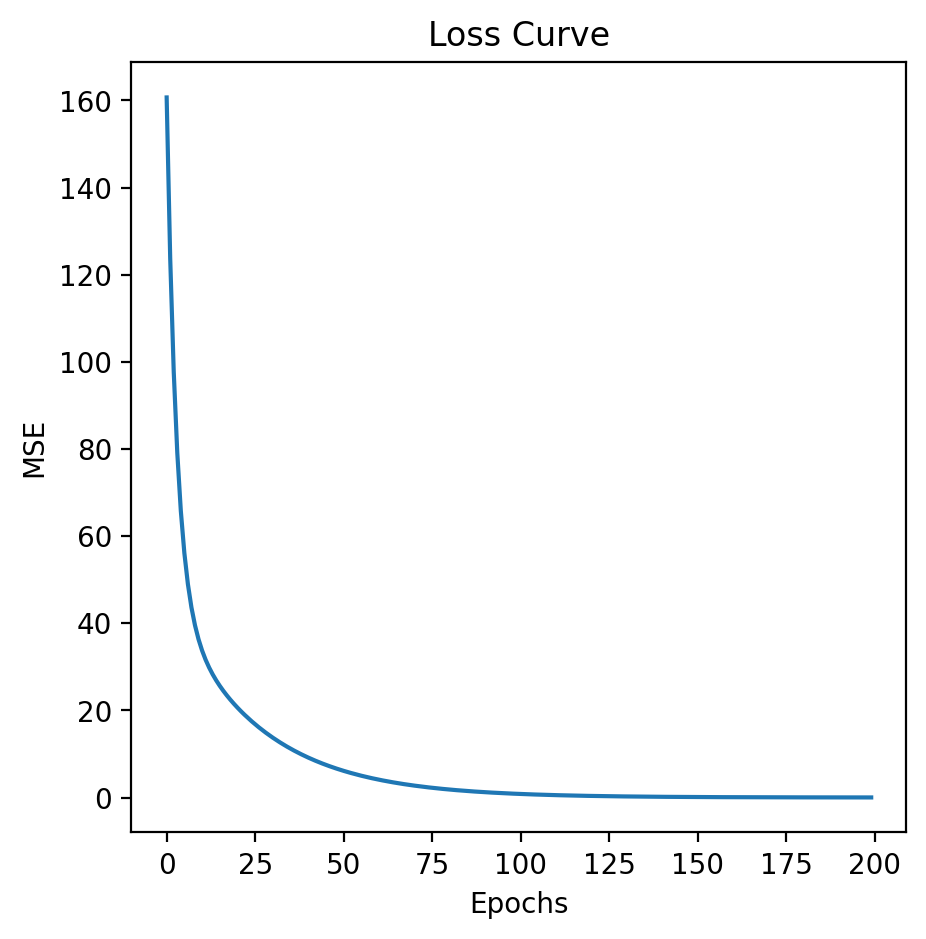

In [90]:
## the loss curve
plt.figure(figsize=(5,5))
plt.plot(*zip(*loss_dict.items()))
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE');

### Logistic Regression

In [115]:
## for this type of regression/classification
## we use the sigmoid function
## and for loss we use binary cross entropy
def sigmoid(x):
    """
    :param x: input values for function
    
    Returns the sigmoid function for the input x.
    """
    return 1/(1 + jnp.exp(-x))
def logistic_model(param, x):
    """
    :param param: parameters, a dictionary. Should have the 
        keys 'w' and 'b', which map to floating point numbers.
    :param x: input values for function
    """
    z = param['w'] * x  + param['b']
    return sigmoid(z)
def bce(param, model, x, y):
    """
    :param param: parameters, to be optimized
    :param model: model to be used for predictions
    :param x: input values for model
    :param y: true values of output
    :
    """
    return -jnp.mean((y * jnp.log(model(param, x)) + (1 - y)* jnp.log(1 - model(param, x))))
## random numbers 
## and true values for our inputs
x = np.linspace(-5, 5, 1000)
true_param = {'w':np.pi, 'b':np.pi*2}
true_y = np.round(logistic_model(true_param, x))

## getting the gradients
bce_grad = grad(bce)
## random params
params = {'w':np.random.normal(),
         'b':np.random.normal()}
loss_dict = {}
lr = 1e-2
## and then the training loop
for e in range(5000):
    ## calculating the loss
    loss_dict[e] = bce(params, logistic_model, x, true_y)
    ## and the dmse
    der_param = bce_grad(params, logistic_model, x, true_y)
    ## and then updating the params
    for k in params:
        params[k] = params[k] - der_param[k] * lr
print(f"True w:{true_param['w']:.2f} calculated {params['w']:.2f}")
print(f"True b:{true_param['b']:.2f} calculated {params['b']:.2f}")

True w:3.14 calculated 1.68
True b:6.28 calculated 2.95


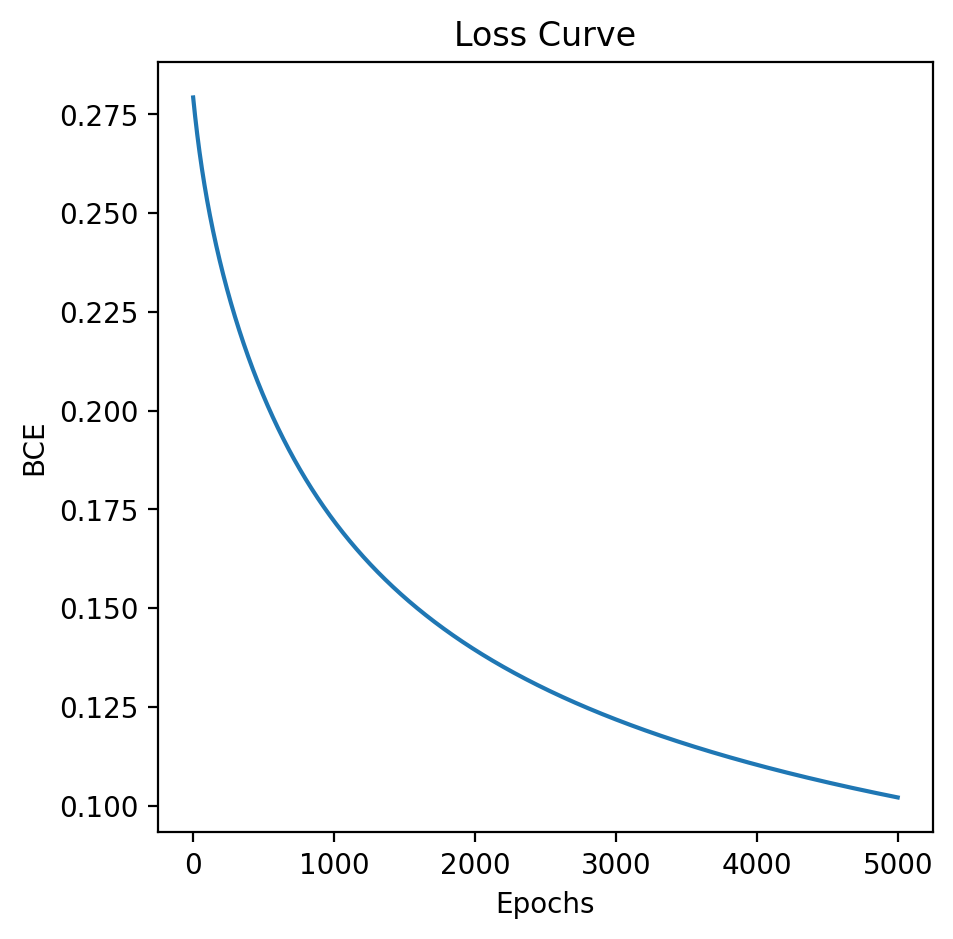

In [111]:
## the loss curve
plt.figure(figsize=(5,5))
plt.plot(*zip(*loss_dict.items()))
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('BCE');

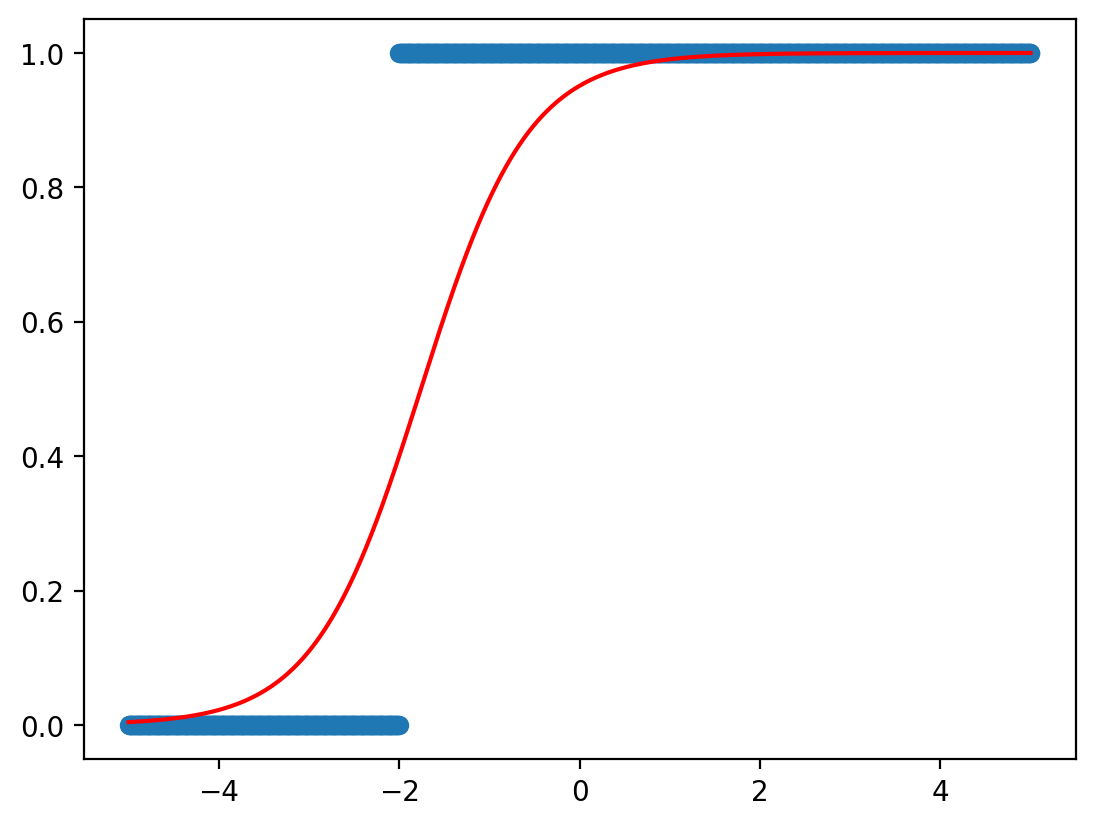

In [113]:
plt.scatter(x, true_y)
plt.plot(x, logistic_model(params, x), color= 'r');

### Neural Network

We will be using the [QSAR biodegradation](https://archive.ics.uci.edu/dataset/254/qsar+biodegradation) from UCI for our model. 

The objective is to predict if a chemical is **biodegradable** (`RB`) and **not ready biodegradable** (`NRB`) not based on 41 measurements.

In [119]:
data = pd.read_csv('https://raw.githubusercontent.com/NikkiShah93/Python/main/data/biodeg.csv', header=None, sep=';')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,RB
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,RB
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,RB
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,RB
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,RB


In [121]:
data.iloc[:, 41].value_counts()

NRB    699
RB     356
Name: 41, dtype: int64

In [129]:
## splitting the data into features and labels
X, y = data.drop(41, axis=1).values, data[41].values
## and converting the strings into int
y = (y == 'RB').astype(int)
X.shape, y.shape

((1055, 41), (1055,))

In [130]:
## splitting into train and eval sets
X_train, X_eval = np.split(X, [int(len(X)*0.8)])
y_train, y_eval = np.split(y, [int(len(X)*0.8)])
X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

((844, 41), (844,), (211, 41), (211,))

In [145]:
## initializing our weights and biases
noise = lambda x:np.random.normal(size=x)
## we will be using two layers in our model
## so we need two sets of weights and biases
params = {
    'w1':noise((X.shape[1], X.shape[1]//2)),
    'b1':noise((X.shape[1]//2,)),
    'w2':noise((X.shape[1]//2, 1)),
    'b2':noise((1,)),
}
## and then the model
def model(param, x):
    """
    :param param: parameters, a dictionary. Should have the 
        keys 'w' and 'b' for each layer.
    :param x: input values for function
    """
    ## we're using tanh for our activation 
    ## in the first layer
    out1 = jnp.tanh(jnp.dot(x, param['w1'])+param['b1'])
    ## and since we're dealing with binary classification
    ## we'll be using sigmoid for the last layer
    out2 = sigmoid(jnp.dot(out1, param['w2'])+param['b2'])
    return out2
## and we're going to use the same loss we used for logistic regression model
grad_loss = grad(bce)
loss_dict = {}
lr = 1e-2
## and then the training loop
for e in range(5000):
    ## adding the loss to our dict for tracking
    loss_dict[e] = bce(params, model, X_train, y_train)
    ## calculating the gradient
    cal_params = grad_loss(params, model, X_train, y_train)
    for k in params:
        params[k] = params[k] - cal_params[k] * lr
    if e % 500 == 0:
        print(f'Epoch {e} Loss is {loss_dict[e]:.2f}')
## evaluating the model
eval_loss = bce(params, model, X_eval, y_eval)
print(f'The evaluation loss : {eval_loss:.2f}')

Epoch 0 Loss is 1.11
Epoch 500 Loss is 0.71
Epoch 1000 Loss is 0.68
Epoch 1500 Loss is 0.67
Epoch 2000 Loss is 0.66
Epoch 2500 Loss is 0.66
Epoch 3000 Loss is 0.65
Epoch 3500 Loss is 0.65
Epoch 4000 Loss is 0.65
Epoch 4500 Loss is 0.65
The evaluation loss : 0.64


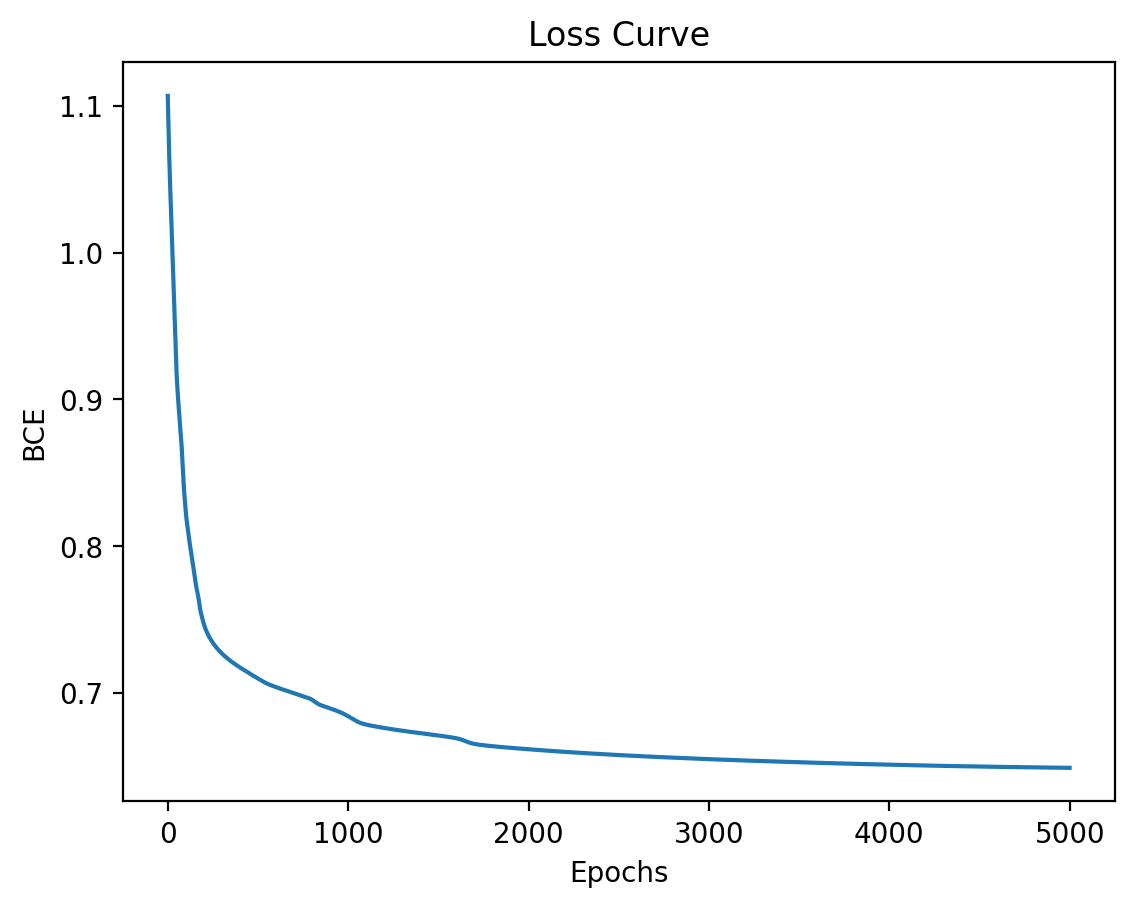

In [146]:
plt.plot(*zip(*loss_dict.items()))
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('BCE');

In [147]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds = np.round(model(params, X_train))
confmat = confusion_matrix(y_true=y_train, y_pred=preds)
confmat

array([[550,   3],
       [289,   2]], dtype=int64)

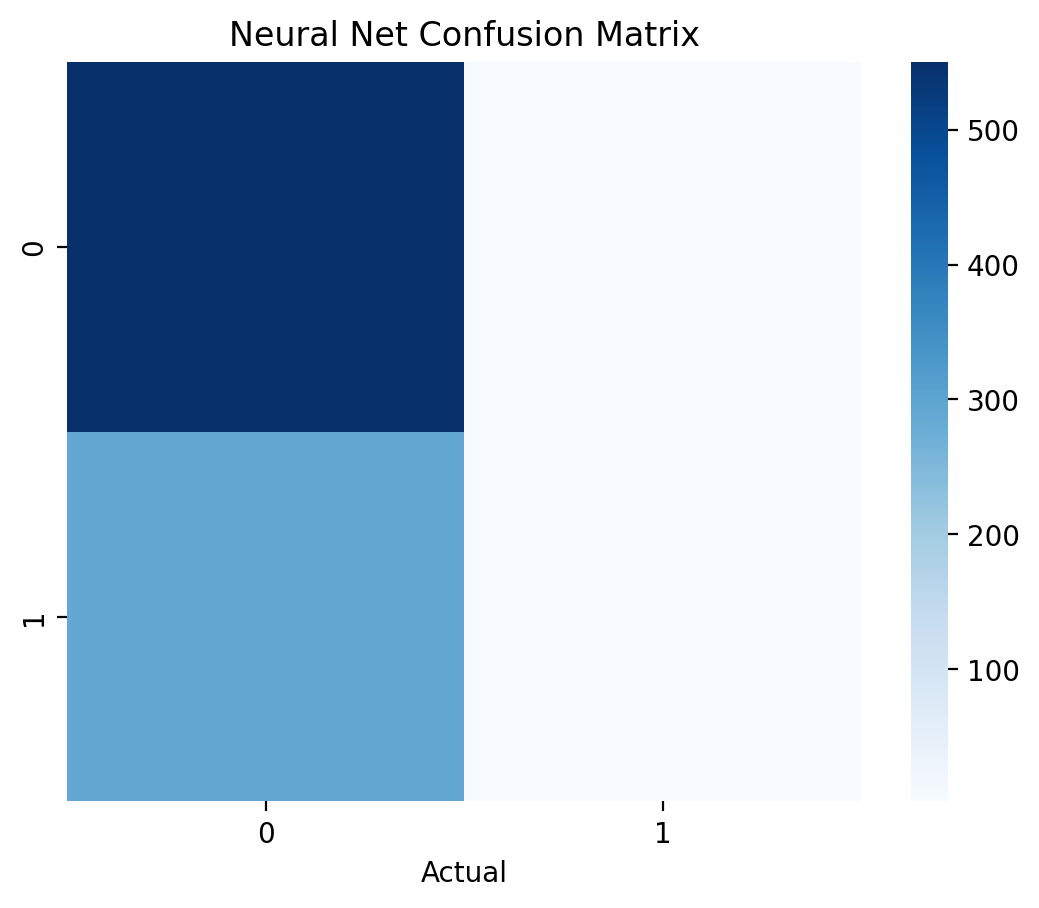

In [148]:
sns.heatmap(confmat,cmap='Blues')
plt.title('Neural Net Confusion Matrix')
plt.xlabel('Predicted')
plt.xlabel('Actual');